<a href="https://colab.research.google.com/github/Thehunk1206/Polyps-Segmentation/blob/master/Polyps_Segmentation_UnetBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/My\ Drive/Polyps\ Segmentation

[Errno 2] No such file or directory: 'drive/My Drive/Polyps Segmentation'
/content/drive/My Drive/Polyps Segmentation


In [ ]:
!tar -xzvf cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a


In [ ]:
!nvidia-smi

Tue Jul  7 14:10:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import glob
from datetime import datetime

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Input, concatenate, Activation, Conv2DTranspose
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import load_model

In [ ]:
tf.__version__

'2.2.0'

# Global vars and Hyperparamaters


In [ ]:
PATH = 'dataset'


IMG_HEIGHT = 512
IMG_WIDTH = 512
EPOCH = 100
BATCH_SIZE = 16
LR = 1e-3

# Building data pipeline and Visualizing images


In [ ]:
 # loading all the file path 
def load_data(path,split = 0.1):
  '''Loads the path name of each images and masks and split it in ratio 80:10:10(train:valid:test)'''
  images =  sorted(glob.glob(os.path.join(path,'images/*')))
  mask =  sorted(glob.glob(os.path.join(path,'masks/*')))
  total_items = len(images)
  valid_items = int(total_items * split)
  test_items = int(total_items * split)

  train_x, valid_x = train_test_split(images,test_size=valid_items, random_state=12)
  train_y, valid_y = train_test_split(mask,test_size=valid_items, random_state=12)

  train_x , test_x = train_test_split(train_x, test_size=test_items, random_state=12)
  train_y , test_y = train_test_split(train_y, test_size=test_items, random_state=12)

  return (train_x,train_y),(valid_x,valid_y),(test_x,test_y)

def read_image(path):
  img_raw = tf.io.read_file(path)
  img = tf.io.decode_image(img_raw)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [IMG_HEIGHT,IMG_WIDTH])
  
  return img

def read_mask(path, plot=True):
  mask_raw = tf.io.read_file(path)
  mask = tf.io.decode_image(mask_raw)
  mask = tf.image.convert_image_dtype(mask, tf.float32)
  #mask = tf.image.rgb_to_grayscale(mask)
  mask = tf.image.resize(mask, [IMG_HEIGHT,IMG_WIDTH])

  return mask

'''
def read_image(path):
  # Read the image from the given path and normalize the pixel values 
  path = path.decode()
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))
  img = img/255.0
  
  return img

def read_mask(path):
  #Read mask image from the given path, normalize the pixel values and expand the dimension
  path = path.decode()
  mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_HEIGHT,IMG_WIDTH))
  mask = mask/255.0
  mask = np.expand_dims(mask, axis=-1)

  return mask
'''

'\ndef read_image(path):\n # Read the image from the given path and normalize the pixel values \n path = path.decode()\n img = cv2.imread(path, cv2.IMREAD_COLOR)\n img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))\n img = img/255.0\n \n return img\n\ndef read_mask(path):\n #Read mask image from the given path, normalize the pixel values and expand the dimension\n path = path.decode()\n mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)\n mask = cv2.resize(mask, (IMG_HEIGHT,IMG_WIDTH))\n mask = mask/255.0\n mask = np.expand_dims(mask, axis=-1)\n\n return mask\n'

### Data pipeline using tf.data

In [ ]:
def parse_data(x,y):
  def _parse(x,y):
    x = read_image(x)
    y = read_mask(y)

    return x,y

  x,y = tf.numpy_function(_parse,[x,y], [tf.float64,tf.float64])
  x.set_shape([IMG_HEIGHT,IMG_WIDTH,3])
  y.set_shape([IMG_HEIGHT,IMG_WIDTH,1])

  return x,y

def tfDataset(x,y, batch=BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.map(parse_data)
  ds = ds.batch(batch)
  return ds


In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)
img = read_mask(train_y[10])
img.shape

TensorShape([512, 512, 1])

### Displaying training images and corresponding mask images

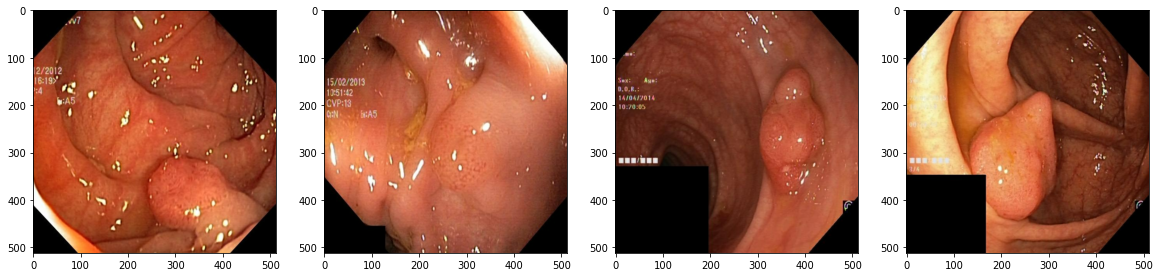

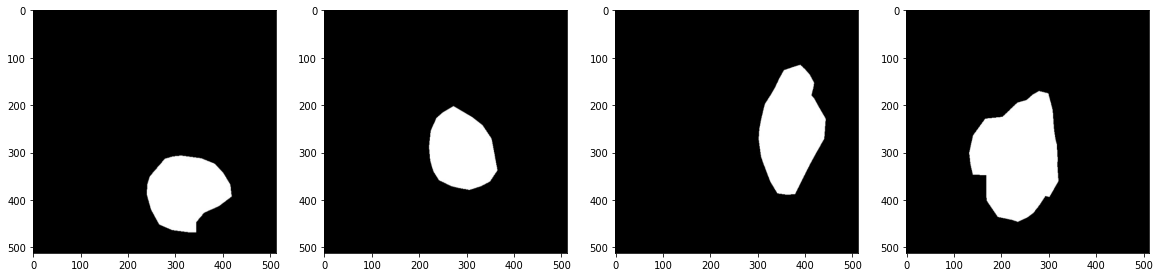

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(4):
  a = fig.add_subplot(1, 4, i+1)
  plt.imshow(read_image(train_x[i+20]))


fig = plt.figure(figsize=(20, 20))
for k in range(4):
  b = fig.add_subplot(1, 4, k+1)
  plt.imshow(read_mask(train_y[k+20]))

plt.show()

# Building model

In [ ]:
def conv_block(input_tensor,n_filters, kernel_size=3):
  '''function to create 2 consecutive Convolutional layers '''
  #layer1
  x = Conv2D(filters=n_filters,kernel_size=(kernel_size,kernel_size),padding='same',kernel_initializer='he_normal')(input_tensor)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  #layer2
  x = Conv2D(filters=n_filters,kernel_size=(kernel_size,kernel_size),padding='same',kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x


def unet(input_img,n_filters=64,dropout_rate=0.2):
  '''returns tf.keras model instance i.e UNET model'''
  #encoder
  c1 = conv_block(input_img, n_filters*1, kernel_size=3) #concatenate with u9
  p1 = MaxPooling2D((2,2))(c1)
  p1 = Dropout(dropout_rate)(p1)

  c2 = conv_block(p1, n_filters*2, kernel_size=3) #concatenate with u8
  p2 = MaxPooling2D((2,2))(c2)
  p2 = Dropout(dropout_rate)(p2)

  c3 = conv_block(p2, n_filters*4, kernel_size=3) #concatenate with u7
  p3 = MaxPooling2D((2,2))(c3)
  p3 = Dropout(dropout_rate)(p3)

  c4 = conv_block(p3, n_filters*8, kernel_size=3) #concatenate with u6
  p4 = MaxPooling2D((2,2))(c4)
  p4 = Dropout(dropout_rate)(p4)

  c5 = conv_block(p4, n_filters*16, kernel_size=3)
  
  #decoder
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6,c4])
  u6 = Dropout(dropout_rate)(u6)
  c6 = conv_block(u6, n_filters * 8, kernel_size=3)

  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7,c3])
  u7 = Dropout(dropout_rate)(u7)
  c7 = conv_block(u7, n_filters * 4, kernel_size=3)

  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8,c2])
  u8 = Dropout(dropout_rate)(u8)
  c8 = conv_block(u8, n_filters * 2, kernel_size=3)

  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9,c1])
  u9 = Dropout(dropout_rate)(u9)
  c9 = conv_block(u9, n_filters * 1, kernel_size=3)

  output = Conv2D(1,(1,1),activation= tf.nn.sigmoid)(c9)

  model = Model(inputs = [input_img], outputs = [output]) 
  return model

In [ ]:
input_img = Input((IMG_HEIGHT,IMG_WIDTH,3))
unet_BN = unet(input_img, n_filters=16)
unet_BN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 512, 512, 16) 64          conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 512, 512, 16) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

## visualizing model

In [ ]:
plot_model(unet_BN, show_shapes=True, to_file='Unet_BN.png')

### Writing Custom Dice loss and Dice coefficient metric

In [ ]:
def dice_coef(y_true, y_pred):
  smooth = 1e-15
  y_true = tf.keras.layers.Flatten()(y_true)
  y_pred = tf.keras.layers.Flatten()(y_pred)
  y_pred = tf.cast(tf.math.greater(y_pred, 0.5),tf.float32)
  intersection = tf.reduce_sum(y_true * y_pred)
  return (2.0 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true,y_pred):
  return tf.keras.losses.binary_crossentropy(y_true,y_pred) + dice_loss(y_true,y_pred)


### Setting up callbacks

In [ ]:
logs_dir = "logs/UnetBN/unetBN_RBG_"+datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [TensorBoard(log_dir = logs_dir,write_images=True,update_freq='batch',histogram_freq=1),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4,min_lr=0.0000001),
             ModelCheckpoint('unetBN.h5',monitor='val_loss',verbose=1,save_best_only=True)]

### Compiling model

In [ ]:
optim = Adam(learning_rate=LR)
metric = [dice_coef,Recall(),Precision()]
unet_BN.compile(optimizer=optim,loss=bce_dice_loss,metrics=metric)

### Model Training

In [ ]:
train_dataset = tfDataset(train_x,train_y)
valid_dataset = tfDataset(valid_x,valid_y)

In [ ]:
train_steps = len(train_x)//BATCH_SIZE
valid_steps = len(valid_x)//BATCH_SIZE

In [ ]:
hist = unet_BN.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 50,
    steps_per_epoch = train_steps,
    validation_steps= valid_steps,
    callbacks = callbacks
)

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.2993 - dice_coef: 0.8250 - recall_1: 0.7701 - precision_1: 0.8730
Epoch 00001: val_loss improved from inf to 0.45473, saving model to unetBN.h5
50/50 [==============================] - 45s 903ms/step - loss: 0.2993 - dice_coef: 0.8250 - recall_1: 0.7701 - precision_1: 0.8730 - val_loss: 0.4547 - val_dice_coef: 0.7313 - val_recall_1: 0.6778 - val_precision_1: 0.7878 - lr: 1.0000e-04
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.2917 - dice_coef: 0.8298 - recall_1: 0.7731 - precision_1: 0.8789
Epoch 00002: val_loss did not improve from 0.45473
50/50 [==============================] - 41s 822ms/step - loss: 0.2917 - dice_coef: 0.8298 - recall_1: 0.7731 - precision_1: 0.8789 - val_loss: 0.4588 - val_dice_coef: 0.7295 - val_recall_1: 0.6726 - val_precision_1: 0.7905 - lr: 1.0000e-04
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.2906 - dice_coef: 0.8300 - recall_1: 0.7731 - p

### Evaluating model

In [ ]:
test_dataset = tfDataset(test_x, test_y, batch=BATCH_SIZE)

test_steps = (len(test_x)//BATCH_SIZE)
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1

unet_BN.evaluate(test_dataset, steps=test_steps)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/UnetBN

# Results

In [ ]:
unet_bn = load_model('unetBN_RGB.h5',custom_objects={'bce_dice_loss':bce_dice_loss,'dice_coef':dice_coef})

In [ ]:
test_dataset = tfDataset(test_x, test_y, batch=BATCH_SIZE)

test_steps = (len(test_x)//BATCH_SIZE)
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1

unet_bn.evaluate(test_dataset, steps=test_steps)

7/7 [==============================] - 107s 15s/step - loss: 0.4465 - dice_coef: 0.7550 - recall_1: 0.7316 - precision_1: 0.7621


[0.4465424418449402,
 0.7550104856491089,
 0.7316338419914246,
 0.7620735168457031]

In [ ]:
def read_image(path):
  '''Read the image from the given path and normalize the pixel values'''
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (IMG_HEIGHT,IMG_WIDTH))
  img = img/255.0
  return img


def read_mask(path):
  '''Read mask image from the given path, normalize the pixel values and expand the dimension'''
  mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_HEIGHT,IMG_WIDTH))
  mask = mask/255.0
  mask = np.expand_dims(mask, axis=-1)

  return mask


def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask,(1,2,0))
    return mask

time taken:  0.6837747097015381


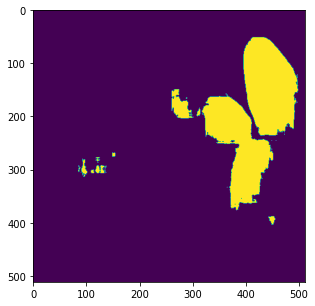

(512, 512, 3)

In [ ]:
import time

x = read_image(test_x[10])

start = time.time()
mask_pred = (unet_bn.predict(np.expand_dims(x,axis=0))[0]>0.5).astype(np.float32)
print("time taken: ",time.time()-start)
mask_pred = np.squeeze(mask_pred)


fig = plt.figure(figsize=(5, 5))
plt.imshow(mask_pred)
plt.show()
x.shape

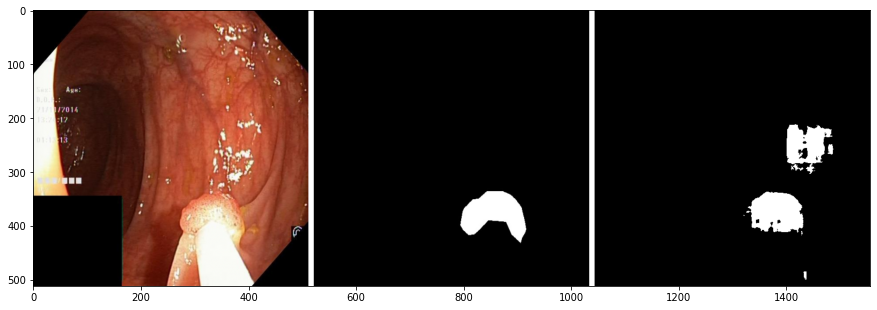

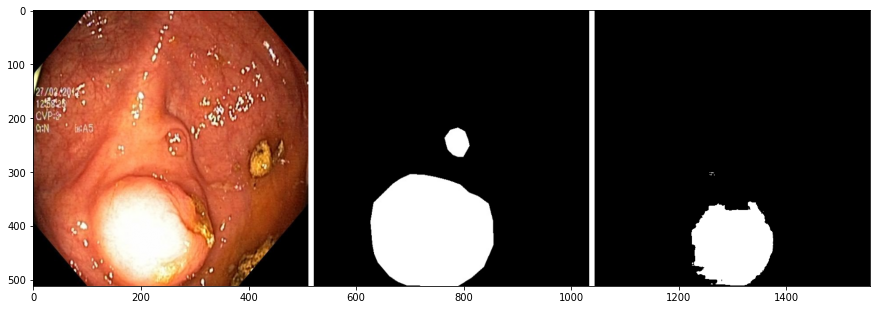

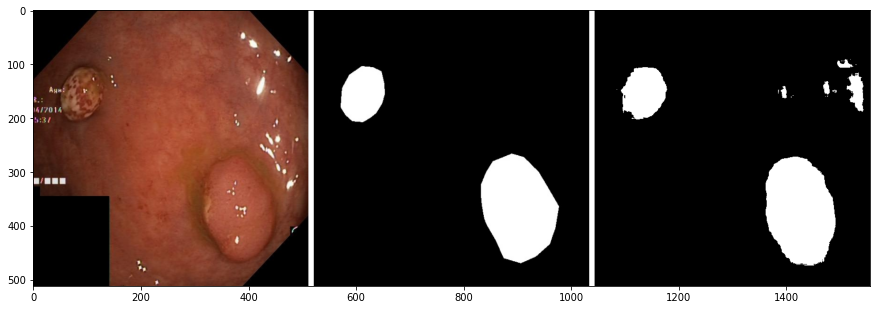

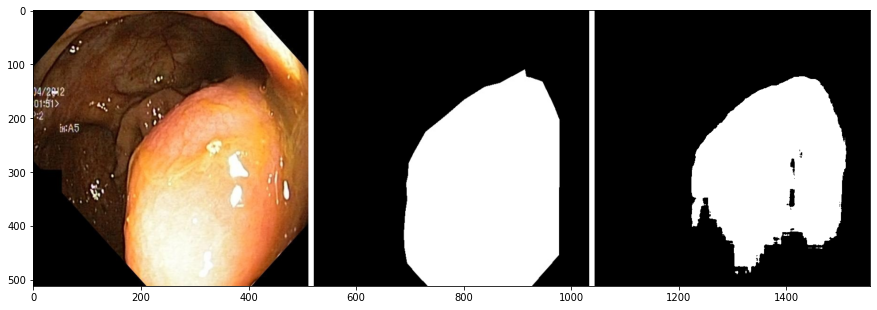

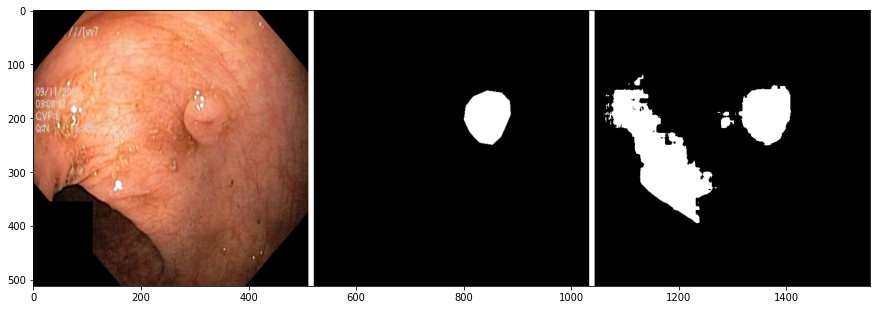

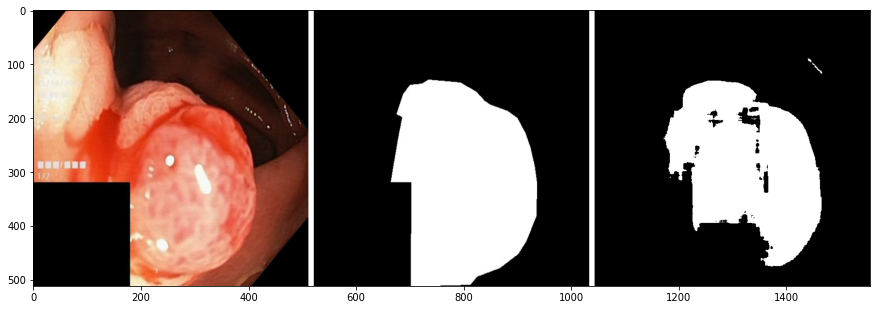

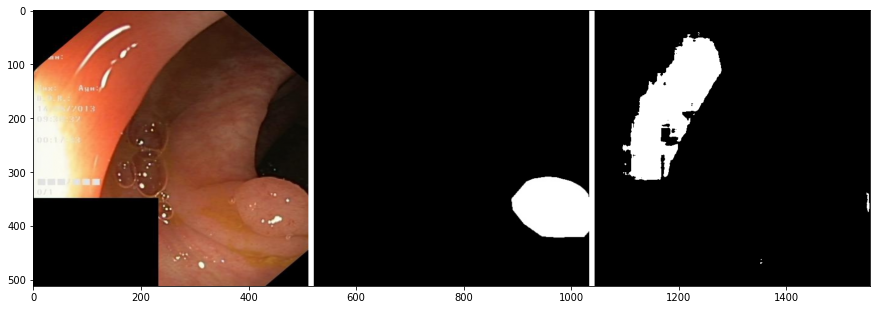

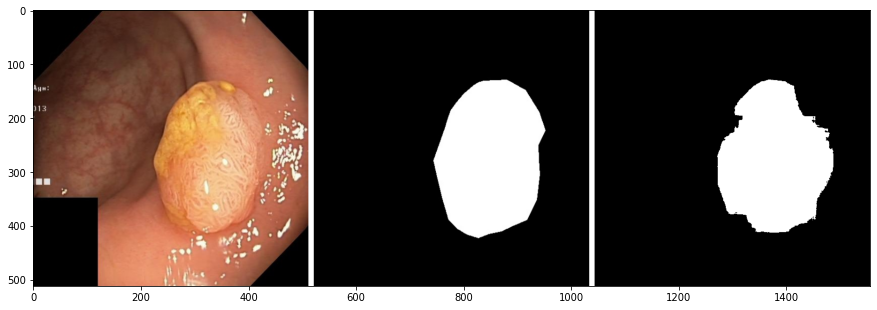

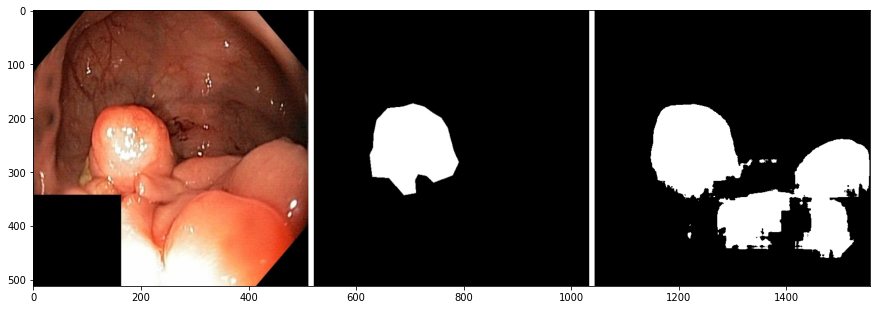

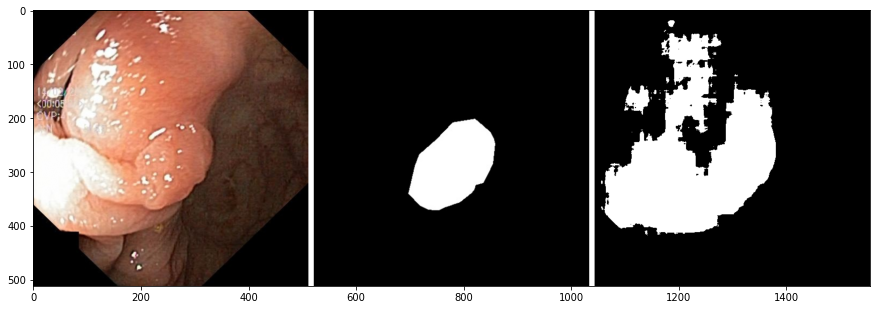

In [ ]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
  x = read_image(x)
  y = read_mask(y)
  y_pred = unet_bn.predict(np.expand_dims(x, axis=0))[0]
  y_pred = (y_pred>0.5).astype(np.int32)
  y_pred = np.squeeze(y_pred)
  h, w, _ = x.shape
  white_line = np.ones((h, 10, 3))

  all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
  ]
  image = np.concatenate(all_images, axis=1)
      
  fig = plt.figure(figsize=(15, 15))
  a = fig.add_subplot(1, 1, 1)
  imgplot = plt.imshow(image)